In [1]:
#Import Keras Modules
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from tqdm.notebook import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import initializers
from sklearn.metrics import accuracy_score, f1_score


In [2]:
from tensorflow.python.client import device_lib

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
    
#print(device_lib.list_local_devices())



No GPU found


In [3]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            new_mask[mask == i,i] = 1
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

In [4]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,istrain, aug_dict1, aug_dict2, image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 4,save_to_dir = None,target_size = (624,624),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
       
    if istrain:
        image_datagen_train = ImageDataGenerator(**aug_dict1)
        image_generator = image_datagen_train.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        shuffle = True,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed,
        subset="training")
        
        mask_generator = image_datagen_train.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        shuffle = True,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed,
        subset="training")
    
    else:
        image_datagen_val = ImageDataGenerator(**aug_dict2)
        image_generator = image_datagen_val.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        shuffle=True,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed,
        subset="validation")
        
        mask_generator = image_datagen_val.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        shuffle=True,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed,
        subset="validation")
    
    data_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in data_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)
        

In [5]:
batch_size = 10
test_split = 0.2

data_gen_args1 = dict(
                    rotation_range=180,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='reflect',
                    validation_split=test_split)

data_gen_args2 = dict(validation_split=test_split)
myGene_train = trainGenerator(batch_size,'Bent_data_624','image_train_valid_XYZ','mask_train_valid_XYZ',istrain=True, aug_dict1=data_gen_args1, aug_dict2=data_gen_args2,
                             flag_multi_class=True, num_class=4, target_size=(624, 624))
myGene_val = trainGenerator(batch_size,'Bent_data_624','image_train_valid_XYZ','mask_train_valid_XYZ',istrain=False, aug_dict1=data_gen_args1, aug_dict2=data_gen_args2,
                             flag_multi_class=True, num_class=4, target_size=(624, 624))

In [6]:
#define the convolution layer
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first convolution layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = initializers.he_normal(seed=1), padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second convolution layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = initializers.he_normal(seed=1), padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [7]:
# define U_net architecture
def get_unet(input_img, n_filters = 16, dropout = 0.0, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(4, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [8]:
# Set input layer size
input_img = Input((624, 624, 1), name='img')
# Set the parameters for Unet
model = get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True)
# Set optimizer, loss function. Set accuracy as metric
model.compile(optimizer=Adam(), loss="categorical_crossentropy",  metrics=["accuracy"])

In [9]:
#Visualize the structure of Unet
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 624, 624, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 624, 624, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 624, 624, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 624, 624, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
# Set criterias for the inversion procedure
# Early Stopping: If the validation set loss function does not decrease in 10 iteration, then early stop.
# ReduceLROnPlateau: If the validation set loss function does not decrease in 5 iteration, then multiply learning rate with factor.
# ModelCheckpoint: save_weights_only=True--Save only the weight,
                  #save_best_only=True -- Only Save the best model with lowest validucation loss
                  #'model-tgs-salt.h5' -- file name
callbacks = [
    EarlyStopping(monitor='val_loss',patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_unet_624_uw_60.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [11]:
file_path_train = "Bent_data_624"
ids_train = next(os.walk(os.path.join(file_path_train, "image_train_valid_XYZ")))[2] 
len(ids_train)

3744

In [12]:
results = model.fit(myGene_train,steps_per_epoch= len(ids_train) * (1-test_split) // batch_size, validation_data = myGene_val, 
    validation_steps = len(ids_train) * (test_split) // batch_size,epochs = 60, callbacks=callbacks)

Found 2996 images belonging to 1 classes.
Found 2996 images belonging to 1 classes.
Epoch 1/60
170/299 [================>.............] - ETA: 0s - loss: 1.8033 - accuracy: 0.05 - ETA: 51:35 - loss: 1.7132 - accuracy: 0.072 - ETA: 1:08:57 - loss: 1.6513 - accuracy: 0.089 - ETA: 1:17:22 - loss: 1.5911 - accuracy: 0.108 - ETA: 1:22:24 - loss: 1.5378 - accuracy: 0.130 - ETA: 1:25:32 - loss: 1.4877 - accuracy: 0.170 - ETA: 1:27:35 - loss: 1.4434 - accuracy: 0.215 - ETA: 1:29:10 - loss: 1.4025 - accuracy: 0.254 - ETA: 1:30:16 - loss: 1.3626 - accuracy: 0.295 - ETA: 1:31:14 - loss: 1.3292 - accuracy: 0.344 - ETA: 1:32:13 - loss: 1.2968 - accuracy: 0.381 - ETA: 1:32:47 - loss: 1.2675 - accuracy: 0.417 - ETA: 1:33:02 - loss: 1.2399 - accuracy: 0.448 - ETA: 1:33:13 - loss: 1.2158 - accuracy: 0.476 - ETA: 1:33:19 - loss: 1.1941 - accuracy: 0.501 - ETA: 1:33:22 - loss: 1.1720 - accuracy: 0.523 - ETA: 1:33:23 - loss: 1.1505 - accuracy: 0.544 - ETA: 1:33:17 - loss: 1.1306 - accuracy: 0.563 - ETA: 1

172/299 [================>.............] - ETA: 0s - loss: 0.0861 - accuracy: 0.96 - ETA: 52:10 - loss: 0.0927 - accuracy: 0.967 - ETA: 1:09:12 - loss: 0.0875 - accuracy: 0.966 - ETA: 1:17:29 - loss: 0.0870 - accuracy: 0.966 - ETA: 1:21:59 - loss: 0.0859 - accuracy: 0.966 - ETA: 1:25:12 - loss: 0.0878 - accuracy: 0.966 - ETA: 1:27:11 - loss: 0.0871 - accuracy: 0.966 - ETA: 1:28:36 - loss: 0.0864 - accuracy: 0.966 - ETA: 1:29:37 - loss: 0.0863 - accuracy: 0.967 - ETA: 1:30:27 - loss: 0.0863 - accuracy: 0.967 - ETA: 1:31:01 - loss: 0.0865 - accuracy: 0.967 - ETA: 1:31:34 - loss: 0.0861 - accuracy: 0.967 - ETA: 1:31:50 - loss: 0.0851 - accuracy: 0.967 - ETA: 1:32:03 - loss: 0.0848 - accuracy: 0.967 - ETA: 1:32:13 - loss: 0.0845 - accuracy: 0.966 - ETA: 1:32:34 - loss: 0.0844 - accuracy: 0.966 - ETA: 1:32:35 - loss: 0.0838 - accuracy: 0.967 - ETA: 1:32:33 - loss: 0.0832 - accuracy: 0.966 - ETA: 1:32:32 - loss: 0.0830 - accuracy: 0.967 - ETA: 1:32:26 - loss: 0.0830 - accuracy: 0.967 - ETA: 

299/299 [==============================] - ETA: 43:35 - loss: 0.0623 - accuracy: 0.966 - ETA: 43:14 - loss: 0.0622 - accuracy: 0.966 - ETA: 42:53 - loss: 0.0621 - accuracy: 0.965 - ETA: 42:33 - loss: 0.0620 - accuracy: 0.965 - ETA: 42:12 - loss: 0.0618 - accuracy: 0.965 - ETA: 41:51 - loss: 0.0617 - accuracy: 0.965 - ETA: 41:30 - loss: 0.0616 - accuracy: 0.965 - ETA: 41:10 - loss: 0.0615 - accuracy: 0.965 - ETA: 40:49 - loss: 0.0614 - accuracy: 0.965 - ETA: 40:28 - loss: 0.0613 - accuracy: 0.965 - ETA: 40:07 - loss: 0.0612 - accuracy: 0.965 - ETA: 39:47 - loss: 0.0611 - accuracy: 0.965 - ETA: 39:26 - loss: 0.0610 - accuracy: 0.965 - ETA: 39:05 - loss: 0.0609 - accuracy: 0.965 - ETA: 38:44 - loss: 0.0608 - accuracy: 0.965 - ETA: 38:24 - loss: 0.0607 - accuracy: 0.965 - ETA: 38:04 - loss: 0.0605 - accuracy: 0.965 - ETA: 37:43 - loss: 0.0604 - accuracy: 0.965 - ETA: 37:22 - loss: 0.0603 - accuracy: 0.965 - ETA: 37:01 - loss: 0.0602 - accuracy: 0.965 - ETA: 36:41 - loss: 0.0601 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0245 - accuracy: 0.96 - ETA: 53:50 - loss: 0.0225 - accuracy: 0.963 - ETA: 57:20 - loss: 0.0220 - accuracy: 0.963 - ETA: 1:09:42 - loss: 0.0216 - accuracy: 0.963 - ETA: 1:16:42 - loss: 0.0218 - accuracy: 0.962 - ETA: 1:21:19 - loss: 0.0219 - accuracy: 0.962 - ETA: 1:24:32 - loss: 0.0219 - accuracy: 0.962 - ETA: 1:26:54 - loss: 0.0218 - accuracy: 0.962 - ETA: 1:28:31 - loss: 0.0220 - accuracy: 0.962 - ETA: 1:29:47 - loss: 0.0218 - accuracy: 0.962 - ETA: 1:30:48 - loss: 0.0215 - accuracy: 0.963 - ETA: 1:31:30 - loss: 0.0213 - accuracy: 0.963 - ETA: 1:32:07 - loss: 0.0211 - accuracy: 0.963 - ETA: 1:32:35 - loss: 0.0209 - accuracy: 0.963 - ETA: 1:33:01 - loss: 0.0212 - accuracy: 0.963 - ETA: 1:33:15 - loss: 0.0209 - accuracy: 0.963 - ETA: 1:33:25 - loss: 0.0206 - accuracy: 0.964 - ETA: 1:33:34 - loss: 0.0205 - accuracy: 0.964 - ETA: 1:33:35 - loss: 0.0206 - accuracy: 0.964 - ETA: 1:33:30 - loss: 0.0205 - accuracy: 0.964 - ETA: 1:

299/299 [==============================] - ETA: 43:37 - loss: 0.0195 - accuracy: 0.964 - ETA: 43:17 - loss: 0.0195 - accuracy: 0.964 - ETA: 42:56 - loss: 0.0195 - accuracy: 0.964 - ETA: 42:36 - loss: 0.0195 - accuracy: 0.964 - ETA: 42:15 - loss: 0.0195 - accuracy: 0.964 - ETA: 41:54 - loss: 0.0195 - accuracy: 0.964 - ETA: 41:34 - loss: 0.0195 - accuracy: 0.964 - ETA: 41:13 - loss: 0.0195 - accuracy: 0.964 - ETA: 40:52 - loss: 0.0195 - accuracy: 0.964 - ETA: 40:31 - loss: 0.0195 - accuracy: 0.964 - ETA: 40:10 - loss: 0.0194 - accuracy: 0.964 - ETA: 39:49 - loss: 0.0194 - accuracy: 0.964 - ETA: 39:29 - loss: 0.0194 - accuracy: 0.964 - ETA: 39:08 - loss: 0.0194 - accuracy: 0.964 - ETA: 38:47 - loss: 0.0194 - accuracy: 0.964 - ETA: 38:27 - loss: 0.0194 - accuracy: 0.964 - ETA: 38:06 - loss: 0.0194 - accuracy: 0.964 - ETA: 37:45 - loss: 0.0194 - accuracy: 0.964 - ETA: 37:24 - loss: 0.0194 - accuracy: 0.964 - ETA: 37:03 - loss: 0.0194 - accuracy: 0.964 - ETA: 36:43 - loss: 0.0194 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0126 - accuracy: 0.96 - ETA: 51:40 - loss: 0.0126 - accuracy: 0.966 - ETA: 1:08:13 - loss: 0.0127 - accuracy: 0.965 - ETA: 1:16:37 - loss: 0.0134 - accuracy: 0.965 - ETA: 1:13:30 - loss: 0.0134 - accuracy: 0.964 - ETA: 1:17:43 - loss: 0.0136 - accuracy: 0.964 - ETA: 1:20:43 - loss: 0.0134 - accuracy: 0.964 - ETA: 1:23:05 - loss: 0.0134 - accuracy: 0.965 - ETA: 1:24:37 - loss: 0.0132 - accuracy: 0.965 - ETA: 1:25:52 - loss: 0.0132 - accuracy: 0.965 - ETA: 1:26:49 - loss: 0.0133 - accuracy: 0.965 - ETA: 1:27:32 - loss: 0.0133 - accuracy: 0.965 - ETA: 1:28:10 - loss: 0.0133 - accuracy: 0.965 - ETA: 1:28:37 - loss: 0.0136 - accuracy: 0.965 - ETA: 1:28:55 - loss: 0.0136 - accuracy: 0.965 - ETA: 1:29:20 - loss: 0.0134 - accuracy: 0.965 - ETA: 1:29:47 - loss: 0.0133 - accuracy: 0.965 - ETA: 1:29:53 - loss: 0.0131 - accuracy: 0.965 - ETA: 1:30:04 - loss: 0.0130 - accuracy: 0.965 - ETA: 1:30:03 - loss: 0.0131 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 43:24 - loss: 0.0132 - accuracy: 0.965 - ETA: 43:03 - loss: 0.0132 - accuracy: 0.965 - ETA: 42:42 - loss: 0.0132 - accuracy: 0.965 - ETA: 42:22 - loss: 0.0132 - accuracy: 0.965 - ETA: 42:01 - loss: 0.0132 - accuracy: 0.965 - ETA: 41:41 - loss: 0.0132 - accuracy: 0.965 - ETA: 41:20 - loss: 0.0132 - accuracy: 0.965 - ETA: 40:59 - loss: 0.0132 - accuracy: 0.965 - ETA: 40:39 - loss: 0.0132 - accuracy: 0.965 - ETA: 40:18 - loss: 0.0132 - accuracy: 0.965 - ETA: 39:57 - loss: 0.0132 - accuracy: 0.965 - ETA: 39:37 - loss: 0.0132 - accuracy: 0.965 - ETA: 39:16 - loss: 0.0132 - accuracy: 0.965 - ETA: 38:55 - loss: 0.0132 - accuracy: 0.965 - ETA: 38:35 - loss: 0.0132 - accuracy: 0.965 - ETA: 38:14 - loss: 0.0132 - accuracy: 0.965 - ETA: 37:54 - loss: 0.0132 - accuracy: 0.965 - ETA: 37:34 - loss: 0.0132 - accuracy: 0.965 - ETA: 37:13 - loss: 0.0132 - accuracy: 0.965 - ETA: 36:53 - loss: 0.0132 - accuracy: 0.965 - ETA: 36:32 - loss: 0.0132 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0104 - accuracy: 0.96 - ETA: 51:40 - loss: 0.0114 - accuracy: 0.966 - ETA: 1:09:39 - loss: 0.0104 - accuracy: 0.965 - ETA: 1:18:11 - loss: 0.0102 - accuracy: 0.965 - ETA: 1:22:40 - loss: 0.0107 - accuracy: 0.965 - ETA: 1:25:31 - loss: 0.0110 - accuracy: 0.965 - ETA: 1:21:46 - loss: 0.0109 - accuracy: 0.965 - ETA: 1:23:54 - loss: 0.0109 - accuracy: 0.965 - ETA: 1:25:25 - loss: 0.0110 - accuracy: 0.965 - ETA: 1:26:36 - loss: 0.0109 - accuracy: 0.965 - ETA: 1:27:46 - loss: 0.0110 - accuracy: 0.965 - ETA: 1:29:21 - loss: 0.0109 - accuracy: 0.965 - ETA: 1:29:42 - loss: 0.0111 - accuracy: 0.964 - ETA: 1:30:06 - loss: 0.0115 - accuracy: 0.964 - ETA: 1:30:23 - loss: 0.0116 - accuracy: 0.964 - ETA: 1:30:33 - loss: 0.0116 - accuracy: 0.964 - ETA: 1:30:40 - loss: 0.0117 - accuracy: 0.964 - ETA: 1:30:41 - loss: 0.0116 - accuracy: 0.964 - ETA: 1:30:41 - loss: 0.0115 - accuracy: 0.964 - ETA: 1:30:40 - loss: 0.0116 - accuracy: 0.964 - ETA: 

299/299 [==============================] - ETA: 43:23 - loss: 0.0113 - accuracy: 0.965 - ETA: 43:02 - loss: 0.0113 - accuracy: 0.965 - ETA: 42:41 - loss: 0.0113 - accuracy: 0.965 - ETA: 42:21 - loss: 0.0113 - accuracy: 0.965 - ETA: 42:01 - loss: 0.0113 - accuracy: 0.965 - ETA: 41:40 - loss: 0.0113 - accuracy: 0.965 - ETA: 41:19 - loss: 0.0113 - accuracy: 0.965 - ETA: 40:59 - loss: 0.0113 - accuracy: 0.965 - ETA: 40:38 - loss: 0.0113 - accuracy: 0.965 - ETA: 40:18 - loss: 0.0113 - accuracy: 0.965 - ETA: 39:57 - loss: 0.0113 - accuracy: 0.965 - ETA: 39:36 - loss: 0.0113 - accuracy: 0.965 - ETA: 39:15 - loss: 0.0113 - accuracy: 0.965 - ETA: 38:55 - loss: 0.0113 - accuracy: 0.965 - ETA: 38:34 - loss: 0.0113 - accuracy: 0.965 - ETA: 38:14 - loss: 0.0113 - accuracy: 0.965 - ETA: 37:53 - loss: 0.0113 - accuracy: 0.965 - ETA: 37:32 - loss: 0.0113 - accuracy: 0.965 - ETA: 37:11 - loss: 0.0113 - accuracy: 0.965 - ETA: 36:51 - loss: 0.0113 - accuracy: 0.965 - ETA: 36:30 - loss: 0.0113 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0095 - accuracy: 0.96 - ETA: 51:31 - loss: 0.0096 - accuracy: 0.967 - ETA: 1:08:16 - loss: 0.0100 - accuracy: 0.965 - ETA: 1:16:34 - loss: 0.0098 - accuracy: 0.965 - ETA: 1:21:15 - loss: 0.0101 - accuracy: 0.965 - ETA: 1:24:38 - loss: 0.0104 - accuracy: 0.965 - ETA: 1:26:40 - loss: 0.0099 - accuracy: 0.966 - ETA: 1:28:01 - loss: 0.0100 - accuracy: 0.966 - ETA: 1:24:43 - loss: 0.0100 - accuracy: 0.965 - ETA: 1:26:00 - loss: 0.0101 - accuracy: 0.965 - ETA: 1:26:54 - loss: 0.0106 - accuracy: 0.965 - ETA: 1:27:38 - loss: 0.0106 - accuracy: 0.964 - ETA: 1:28:11 - loss: 0.0104 - accuracy: 0.964 - ETA: 1:28:38 - loss: 0.0105 - accuracy: 0.964 - ETA: 1:28:56 - loss: 0.0106 - accuracy: 0.964 - ETA: 1:29:10 - loss: 0.0106 - accuracy: 0.964 - ETA: 1:29:18 - loss: 0.0108 - accuracy: 0.964 - ETA: 1:29:30 - loss: 0.0108 - accuracy: 0.964 - ETA: 1:29:54 - loss: 0.0107 - accuracy: 0.965 - ETA: 1:29:54 - loss: 0.0107 - accuracy: 0.964 - ETA: 

299/299 [==============================] - ETA: 43:43 - loss: 0.0105 - accuracy: 0.965 - ETA: 43:22 - loss: 0.0105 - accuracy: 0.965 - ETA: 43:01 - loss: 0.0105 - accuracy: 0.965 - ETA: 42:40 - loss: 0.0105 - accuracy: 0.965 - ETA: 42:19 - loss: 0.0105 - accuracy: 0.965 - ETA: 41:59 - loss: 0.0105 - accuracy: 0.965 - ETA: 41:38 - loss: 0.0105 - accuracy: 0.965 - ETA: 41:17 - loss: 0.0105 - accuracy: 0.965 - ETA: 40:56 - loss: 0.0105 - accuracy: 0.965 - ETA: 40:35 - loss: 0.0105 - accuracy: 0.965 - ETA: 40:15 - loss: 0.0105 - accuracy: 0.965 - ETA: 39:54 - loss: 0.0105 - accuracy: 0.965 - ETA: 39:33 - loss: 0.0105 - accuracy: 0.965 - ETA: 39:13 - loss: 0.0105 - accuracy: 0.965 - ETA: 38:52 - loss: 0.0105 - accuracy: 0.965 - ETA: 38:31 - loss: 0.0105 - accuracy: 0.965 - ETA: 38:10 - loss: 0.0105 - accuracy: 0.965 - ETA: 37:50 - loss: 0.0105 - accuracy: 0.965 - ETA: 37:29 - loss: 0.0105 - accuracy: 0.965 - ETA: 37:08 - loss: 0.0105 - accuracy: 0.965 - ETA: 36:47 - loss: 0.0105 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0088 - accuracy: 0.96 - ETA: 51:06 - loss: 0.0105 - accuracy: 0.964 - ETA: 1:07:39 - loss: 0.0099 - accuracy: 0.964 - ETA: 1:17:43 - loss: 0.0092 - accuracy: 0.964 - ETA: 1:22:41 - loss: 0.0097 - accuracy: 0.964 - ETA: 1:25:32 - loss: 0.0099 - accuracy: 0.964 - ETA: 1:27:43 - loss: 0.0104 - accuracy: 0.964 - ETA: 1:28:51 - loss: 0.0100 - accuracy: 0.964 - ETA: 1:29:54 - loss: 0.0098 - accuracy: 0.964 - ETA: 1:30:39 - loss: 0.0097 - accuracy: 0.965 - ETA: 1:27:39 - loss: 0.0096 - accuracy: 0.965 - ETA: 1:28:20 - loss: 0.0095 - accuracy: 0.965 - ETA: 1:28:50 - loss: 0.0094 - accuracy: 0.965 - ETA: 1:29:10 - loss: 0.0093 - accuracy: 0.965 - ETA: 1:29:30 - loss: 0.0092 - accuracy: 0.965 - ETA: 1:29:43 - loss: 0.0093 - accuracy: 0.965 - ETA: 1:29:56 - loss: 0.0095 - accuracy: 0.965 - ETA: 1:30:04 - loss: 0.0095 - accuracy: 0.965 - ETA: 1:30:08 - loss: 0.0095 - accuracy: 0.965 - ETA: 1:30:08 - loss: 0.0095 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 43:19 - loss: 0.0097 - accuracy: 0.965 - ETA: 42:58 - loss: 0.0097 - accuracy: 0.965 - ETA: 42:38 - loss: 0.0097 - accuracy: 0.965 - ETA: 42:17 - loss: 0.0097 - accuracy: 0.965 - ETA: 41:57 - loss: 0.0097 - accuracy: 0.965 - ETA: 41:37 - loss: 0.0097 - accuracy: 0.965 - ETA: 41:16 - loss: 0.0097 - accuracy: 0.965 - ETA: 40:56 - loss: 0.0097 - accuracy: 0.965 - ETA: 40:35 - loss: 0.0097 - accuracy: 0.965 - ETA: 40:15 - loss: 0.0097 - accuracy: 0.965 - ETA: 39:54 - loss: 0.0097 - accuracy: 0.965 - ETA: 39:34 - loss: 0.0097 - accuracy: 0.965 - ETA: 39:13 - loss: 0.0097 - accuracy: 0.965 - ETA: 38:52 - loss: 0.0097 - accuracy: 0.965 - ETA: 38:32 - loss: 0.0097 - accuracy: 0.965 - ETA: 38:11 - loss: 0.0097 - accuracy: 0.965 - ETA: 37:51 - loss: 0.0097 - accuracy: 0.965 - ETA: 37:30 - loss: 0.0097 - accuracy: 0.965 - ETA: 37:10 - loss: 0.0097 - accuracy: 0.965 - ETA: 36:49 - loss: 0.0097 - accuracy: 0.965 - ETA: 36:28 - loss: 0.0097 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0074 - accuracy: 0.96 - ETA: 50:48 - loss: 0.0092 - accuracy: 0.965 - ETA: 1:07:54 - loss: 0.0087 - accuracy: 0.965 - ETA: 1:16:35 - loss: 0.0085 - accuracy: 0.965 - ETA: 1:21:11 - loss: 0.0088 - accuracy: 0.965 - ETA: 1:24:27 - loss: 0.0087 - accuracy: 0.966 - ETA: 1:26:41 - loss: 0.0085 - accuracy: 0.966 - ETA: 1:28:01 - loss: 0.0088 - accuracy: 0.966 - ETA: 1:29:05 - loss: 0.0089 - accuracy: 0.965 - ETA: 1:29:53 - loss: 0.0091 - accuracy: 0.965 - ETA: 1:30:30 - loss: 0.0090 - accuracy: 0.965 - ETA: 1:30:57 - loss: 0.0092 - accuracy: 0.965 - ETA: 1:28:19 - loss: 0.0092 - accuracy: 0.965 - ETA: 1:28:49 - loss: 0.0095 - accuracy: 0.964 - ETA: 1:29:13 - loss: 0.0093 - accuracy: 0.965 - ETA: 1:29:24 - loss: 0.0095 - accuracy: 0.965 - ETA: 1:29:35 - loss: 0.0096 - accuracy: 0.965 - ETA: 1:29:43 - loss: 0.0095 - accuracy: 0.965 - ETA: 1:29:48 - loss: 0.0098 - accuracy: 0.965 - ETA: 1:29:52 - loss: 0.0097 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 43:37 - loss: 0.0094 - accuracy: 0.965 - ETA: 43:16 - loss: 0.0094 - accuracy: 0.965 - ETA: 42:56 - loss: 0.0094 - accuracy: 0.965 - ETA: 42:35 - loss: 0.0094 - accuracy: 0.965 - ETA: 42:14 - loss: 0.0094 - accuracy: 0.965 - ETA: 41:54 - loss: 0.0094 - accuracy: 0.965 - ETA: 41:33 - loss: 0.0094 - accuracy: 0.965 - ETA: 41:12 - loss: 0.0094 - accuracy: 0.965 - ETA: 40:51 - loss: 0.0094 - accuracy: 0.965 - ETA: 40:30 - loss: 0.0094 - accuracy: 0.965 - ETA: 40:10 - loss: 0.0094 - accuracy: 0.965 - ETA: 39:49 - loss: 0.0094 - accuracy: 0.965 - ETA: 39:28 - loss: 0.0094 - accuracy: 0.965 - ETA: 39:07 - loss: 0.0094 - accuracy: 0.965 - ETA: 38:47 - loss: 0.0094 - accuracy: 0.965 - ETA: 38:26 - loss: 0.0094 - accuracy: 0.965 - ETA: 38:05 - loss: 0.0094 - accuracy: 0.965 - ETA: 37:45 - loss: 0.0094 - accuracy: 0.965 - ETA: 37:24 - loss: 0.0094 - accuracy: 0.965 - ETA: 37:03 - loss: 0.0094 - accuracy: 0.965 - ETA: 36:43 - loss: 0.0094 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0108 - accuracy: 0.96 - ETA: 51:07 - loss: 0.0084 - accuracy: 0.965 - ETA: 1:07:50 - loss: 0.0087 - accuracy: 0.964 - ETA: 1:16:00 - loss: 0.0092 - accuracy: 0.965 - ETA: 1:20:48 - loss: 0.0090 - accuracy: 0.964 - ETA: 1:23:56 - loss: 0.0091 - accuracy: 0.965 - ETA: 1:26:28 - loss: 0.0089 - accuracy: 0.965 - ETA: 1:28:12 - loss: 0.0086 - accuracy: 0.965 - ETA: 1:29:10 - loss: 0.0086 - accuracy: 0.965 - ETA: 1:29:53 - loss: 0.0085 - accuracy: 0.965 - ETA: 1:30:28 - loss: 0.0084 - accuracy: 0.965 - ETA: 1:30:56 - loss: 0.0084 - accuracy: 0.965 - ETA: 1:31:51 - loss: 0.0088 - accuracy: 0.965 - ETA: 1:31:58 - loss: 0.0088 - accuracy: 0.965 - ETA: 1:29:33 - loss: 0.0088 - accuracy: 0.965 - ETA: 1:29:44 - loss: 0.0087 - accuracy: 0.965 - ETA: 1:29:54 - loss: 0.0087 - accuracy: 0.965 - ETA: 1:30:00 - loss: 0.0087 - accuracy: 0.965 - ETA: 1:30:02 - loss: 0.0087 - accuracy: 0.965 - ETA: 1:30:01 - loss: 0.0087 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 43:10 - loss: 0.0088 - accuracy: 0.965 - ETA: 42:49 - loss: 0.0088 - accuracy: 0.965 - ETA: 42:29 - loss: 0.0089 - accuracy: 0.965 - ETA: 42:09 - loss: 0.0089 - accuracy: 0.965 - ETA: 41:48 - loss: 0.0089 - accuracy: 0.965 - ETA: 41:27 - loss: 0.0089 - accuracy: 0.965 - ETA: 41:07 - loss: 0.0089 - accuracy: 0.965 - ETA: 40:46 - loss: 0.0089 - accuracy: 0.965 - ETA: 40:26 - loss: 0.0089 - accuracy: 0.965 - ETA: 40:06 - loss: 0.0089 - accuracy: 0.965 - ETA: 39:46 - loss: 0.0089 - accuracy: 0.965 - ETA: 39:25 - loss: 0.0089 - accuracy: 0.965 - ETA: 39:05 - loss: 0.0089 - accuracy: 0.965 - ETA: 38:44 - loss: 0.0089 - accuracy: 0.965 - ETA: 38:24 - loss: 0.0089 - accuracy: 0.965 - ETA: 38:03 - loss: 0.0089 - accuracy: 0.965 - ETA: 37:43 - loss: 0.0089 - accuracy: 0.965 - ETA: 37:22 - loss: 0.0089 - accuracy: 0.965 - ETA: 37:02 - loss: 0.0089 - accuracy: 0.965 - ETA: 36:41 - loss: 0.0089 - accuracy: 0.965 - ETA: 36:20 - loss: 0.0089 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0125 - accuracy: 0.96 - ETA: 51:26 - loss: 0.0102 - accuracy: 0.964 - ETA: 1:08:06 - loss: 0.0099 - accuracy: 0.964 - ETA: 1:16:27 - loss: 0.0094 - accuracy: 0.965 - ETA: 1:21:26 - loss: 0.0093 - accuracy: 0.964 - ETA: 1:24:32 - loss: 0.0091 - accuracy: 0.965 - ETA: 1:26:47 - loss: 0.0092 - accuracy: 0.965 - ETA: 1:28:15 - loss: 0.0090 - accuracy: 0.965 - ETA: 1:29:17 - loss: 0.0093 - accuracy: 0.965 - ETA: 1:30:00 - loss: 0.0092 - accuracy: 0.965 - ETA: 1:30:33 - loss: 0.0091 - accuracy: 0.965 - ETA: 1:30:58 - loss: 0.0090 - accuracy: 0.965 - ETA: 1:31:17 - loss: 0.0089 - accuracy: 0.965 - ETA: 1:31:24 - loss: 0.0091 - accuracy: 0.965 - ETA: 1:31:29 - loss: 0.0092 - accuracy: 0.965 - ETA: 1:31:29 - loss: 0.0093 - accuracy: 0.964 - ETA: 1:29:16 - loss: 0.0093 - accuracy: 0.964 - ETA: 1:29:22 - loss: 0.0094 - accuracy: 0.964 - ETA: 1:29:31 - loss: 0.0093 - accuracy: 0.964 - ETA: 1:29:33 - loss: 0.0092 - accuracy: 0.964 - ETA: 

299/299 [==============================] - ETA: 43:13 - loss: 0.0088 - accuracy: 0.965 - ETA: 42:53 - loss: 0.0088 - accuracy: 0.965 - ETA: 42:32 - loss: 0.0088 - accuracy: 0.965 - ETA: 42:12 - loss: 0.0088 - accuracy: 0.965 - ETA: 41:52 - loss: 0.0088 - accuracy: 0.965 - ETA: 41:31 - loss: 0.0088 - accuracy: 0.965 - ETA: 41:11 - loss: 0.0088 - accuracy: 0.965 - ETA: 40:50 - loss: 0.0088 - accuracy: 0.965 - ETA: 40:30 - loss: 0.0088 - accuracy: 0.965 - ETA: 40:10 - loss: 0.0088 - accuracy: 0.965 - ETA: 39:49 - loss: 0.0088 - accuracy: 0.965 - ETA: 39:29 - loss: 0.0088 - accuracy: 0.965 - ETA: 39:09 - loss: 0.0088 - accuracy: 0.965 - ETA: 38:49 - loss: 0.0088 - accuracy: 0.965 - ETA: 38:29 - loss: 0.0088 - accuracy: 0.965 - ETA: 38:08 - loss: 0.0088 - accuracy: 0.965 - ETA: 37:48 - loss: 0.0088 - accuracy: 0.965 - ETA: 37:27 - loss: 0.0088 - accuracy: 0.965 - ETA: 37:06 - loss: 0.0088 - accuracy: 0.965 - ETA: 36:46 - loss: 0.0088 - accuracy: 0.965 - ETA: 36:25 - loss: 0.0088 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0083 - accuracy: 0.96 - ETA: 50:39 - loss: 0.0089 - accuracy: 0.965 - ETA: 1:07:47 - loss: 0.0088 - accuracy: 0.965 - ETA: 1:16:12 - loss: 0.0086 - accuracy: 0.964 - ETA: 1:21:08 - loss: 0.0085 - accuracy: 0.964 - ETA: 1:24:21 - loss: 0.0082 - accuracy: 0.965 - ETA: 1:26:19 - loss: 0.0087 - accuracy: 0.965 - ETA: 1:27:48 - loss: 0.0086 - accuracy: 0.965 - ETA: 1:28:56 - loss: 0.0084 - accuracy: 0.965 - ETA: 1:29:43 - loss: 0.0085 - accuracy: 0.965 - ETA: 1:30:22 - loss: 0.0085 - accuracy: 0.965 - ETA: 1:31:16 - loss: 0.0084 - accuracy: 0.965 - ETA: 1:31:38 - loss: 0.0084 - accuracy: 0.965 - ETA: 1:31:50 - loss: 0.0084 - accuracy: 0.965 - ETA: 1:31:58 - loss: 0.0084 - accuracy: 0.965 - ETA: 1:32:00 - loss: 0.0084 - accuracy: 0.965 - ETA: 1:32:02 - loss: 0.0086 - accuracy: 0.965 - ETA: 1:31:59 - loss: 0.0085 - accuracy: 0.965 - ETA: 1:29:57 - loss: 0.0085 - accuracy: 0.965 - ETA: 1:29:55 - loss: 0.0084 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 43:20 - loss: 0.0082 - accuracy: 0.965 - ETA: 42:59 - loss: 0.0082 - accuracy: 0.965 - ETA: 42:38 - loss: 0.0082 - accuracy: 0.965 - ETA: 42:18 - loss: 0.0082 - accuracy: 0.965 - ETA: 41:57 - loss: 0.0082 - accuracy: 0.965 - ETA: 41:37 - loss: 0.0082 - accuracy: 0.965 - ETA: 41:16 - loss: 0.0082 - accuracy: 0.965 - ETA: 40:55 - loss: 0.0082 - accuracy: 0.965 - ETA: 40:38 - loss: 0.0082 - accuracy: 0.965 - ETA: 40:18 - loss: 0.0082 - accuracy: 0.965 - ETA: 39:58 - loss: 0.0082 - accuracy: 0.965 - ETA: 39:37 - loss: 0.0082 - accuracy: 0.965 - ETA: 39:17 - loss: 0.0082 - accuracy: 0.965 - ETA: 38:57 - loss: 0.0082 - accuracy: 0.965 - ETA: 38:36 - loss: 0.0082 - accuracy: 0.965 - ETA: 38:16 - loss: 0.0082 - accuracy: 0.965 - ETA: 37:55 - loss: 0.0082 - accuracy: 0.965 - ETA: 37:35 - loss: 0.0082 - accuracy: 0.965 - ETA: 37:14 - loss: 0.0082 - accuracy: 0.965 - ETA: 36:53 - loss: 0.0082 - accuracy: 0.965 - ETA: 36:33 - loss: 0.0082 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0072 - accuracy: 0.96 - ETA: 51:33 - loss: 0.0071 - accuracy: 0.964 - ETA: 1:08:08 - loss: 0.0077 - accuracy: 0.964 - ETA: 1:16:34 - loss: 0.0075 - accuracy: 0.964 - ETA: 1:21:24 - loss: 0.0077 - accuracy: 0.964 - ETA: 1:24:38 - loss: 0.0078 - accuracy: 0.965 - ETA: 1:26:50 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:28:29 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:29:40 - loss: 0.0078 - accuracy: 0.965 - ETA: 1:30:29 - loss: 0.0080 - accuracy: 0.965 - ETA: 1:30:59 - loss: 0.0079 - accuracy: 0.965 - ETA: 1:31:24 - loss: 0.0078 - accuracy: 0.965 - ETA: 1:31:47 - loss: 0.0079 - accuracy: 0.965 - ETA: 1:32:01 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:32:10 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:32:17 - loss: 0.0079 - accuracy: 0.965 - ETA: 1:32:16 - loss: 0.0079 - accuracy: 0.965 - ETA: 1:32:16 - loss: 0.0082 - accuracy: 0.965 - ETA: 1:32:14 - loss: 0.0082 - accuracy: 0.965 - ETA: 1:32:09 - loss: 0.0082 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 43:46 - loss: 0.0080 - accuracy: 0.965 - ETA: 43:25 - loss: 0.0080 - accuracy: 0.965 - ETA: 43:04 - loss: 0.0080 - accuracy: 0.965 - ETA: 42:43 - loss: 0.0080 - accuracy: 0.965 - ETA: 42:22 - loss: 0.0080 - accuracy: 0.965 - ETA: 42:01 - loss: 0.0080 - accuracy: 0.965 - ETA: 41:41 - loss: 0.0080 - accuracy: 0.965 - ETA: 41:20 - loss: 0.0081 - accuracy: 0.965 - ETA: 40:59 - loss: 0.0081 - accuracy: 0.965 - ETA: 40:38 - loss: 0.0081 - accuracy: 0.965 - ETA: 40:17 - loss: 0.0081 - accuracy: 0.965 - ETA: 39:56 - loss: 0.0080 - accuracy: 0.965 - ETA: 39:35 - loss: 0.0081 - accuracy: 0.965 - ETA: 39:14 - loss: 0.0081 - accuracy: 0.965 - ETA: 38:54 - loss: 0.0081 - accuracy: 0.965 - ETA: 38:33 - loss: 0.0081 - accuracy: 0.965 - ETA: 38:12 - loss: 0.0080 - accuracy: 0.965 - ETA: 37:51 - loss: 0.0081 - accuracy: 0.965 - ETA: 37:30 - loss: 0.0080 - accuracy: 0.965 - ETA: 37:09 - loss: 0.0080 - accuracy: 0.965 - ETA: 36:49 - loss: 0.0081 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0078 - accuracy: 0.96 - ETA: 52:16 - loss: 0.0080 - accuracy: 0.964 - ETA: 1:08:35 - loss: 0.0079 - accuracy: 0.965 - ETA: 1:16:31 - loss: 0.0075 - accuracy: 0.965 - ETA: 1:21:16 - loss: 0.0076 - accuracy: 0.965 - ETA: 1:24:11 - loss: 0.0078 - accuracy: 0.965 - ETA: 1:26:17 - loss: 0.0079 - accuracy: 0.965 - ETA: 1:28:07 - loss: 0.0082 - accuracy: 0.964 - ETA: 1:29:36 - loss: 0.0081 - accuracy: 0.965 - ETA: 1:30:22 - loss: 0.0080 - accuracy: 0.965 - ETA: 1:30:57 - loss: 0.0080 - accuracy: 0.965 - ETA: 1:31:17 - loss: 0.0082 - accuracy: 0.965 - ETA: 1:31:37 - loss: 0.0080 - accuracy: 0.965 - ETA: 1:31:48 - loss: 0.0081 - accuracy: 0.965 - ETA: 1:31:54 - loss: 0.0081 - accuracy: 0.965 - ETA: 1:31:57 - loss: 0.0080 - accuracy: 0.965 - ETA: 1:31:57 - loss: 0.0078 - accuracy: 0.965 - ETA: 1:31:57 - loss: 0.0079 - accuracy: 0.965 - ETA: 1:31:55 - loss: 0.0080 - accuracy: 0.965 - ETA: 1:31:49 - loss: 0.0080 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 43:20 - loss: 0.0081 - accuracy: 0.965 - ETA: 42:59 - loss: 0.0081 - accuracy: 0.965 - ETA: 42:39 - loss: 0.0081 - accuracy: 0.965 - ETA: 42:18 - loss: 0.0081 - accuracy: 0.965 - ETA: 41:57 - loss: 0.0081 - accuracy: 0.965 - ETA: 41:37 - loss: 0.0081 - accuracy: 0.965 - ETA: 41:16 - loss: 0.0081 - accuracy: 0.965 - ETA: 40:56 - loss: 0.0081 - accuracy: 0.965 - ETA: 40:35 - loss: 0.0081 - accuracy: 0.965 - ETA: 40:16 - loss: 0.0081 - accuracy: 0.965 - ETA: 39:55 - loss: 0.0081 - accuracy: 0.965 - ETA: 39:35 - loss: 0.0081 - accuracy: 0.965 - ETA: 39:14 - loss: 0.0081 - accuracy: 0.965 - ETA: 38:53 - loss: 0.0081 - accuracy: 0.965 - ETA: 38:33 - loss: 0.0081 - accuracy: 0.965 - ETA: 38:12 - loss: 0.0081 - accuracy: 0.965 - ETA: 37:52 - loss: 0.0081 - accuracy: 0.965 - ETA: 37:31 - loss: 0.0081 - accuracy: 0.965 - ETA: 37:10 - loss: 0.0081 - accuracy: 0.965 - ETA: 36:50 - loss: 0.0081 - accuracy: 0.965 - ETA: 36:29 - loss: 0.0081 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0092 - accuracy: 0.96 - ETA: 51:32 - loss: 0.0085 - accuracy: 0.965 - ETA: 1:08:36 - loss: 0.0091 - accuracy: 0.964 - ETA: 1:16:44 - loss: 0.0080 - accuracy: 0.965 - ETA: 1:21:23 - loss: 0.0080 - accuracy: 0.965 - ETA: 1:24:23 - loss: 0.0076 - accuracy: 0.965 - ETA: 1:26:32 - loss: 0.0074 - accuracy: 0.965 - ETA: 1:27:59 - loss: 0.0073 - accuracy: 0.966 - ETA: 1:29:01 - loss: 0.0072 - accuracy: 0.966 - ETA: 1:29:55 - loss: 0.0076 - accuracy: 0.965 - ETA: 1:30:24 - loss: 0.0076 - accuracy: 0.965 - ETA: 1:30:47 - loss: 0.0075 - accuracy: 0.965 - ETA: 1:31:08 - loss: 0.0075 - accuracy: 0.965 - ETA: 1:31:23 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:31:32 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:31:35 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:31:36 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:31:32 - loss: 0.0076 - accuracy: 0.965 - ETA: 1:31:29 - loss: 0.0076 - accuracy: 0.965 - ETA: 1:31:24 - loss: 0.0077 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 43:18 - loss: 0.0079 - accuracy: 0.965 - ETA: 42:57 - loss: 0.0079 - accuracy: 0.965 - ETA: 42:36 - loss: 0.0079 - accuracy: 0.965 - ETA: 42:16 - loss: 0.0079 - accuracy: 0.965 - ETA: 41:55 - loss: 0.0079 - accuracy: 0.965 - ETA: 41:35 - loss: 0.0079 - accuracy: 0.965 - ETA: 41:14 - loss: 0.0079 - accuracy: 0.965 - ETA: 40:54 - loss: 0.0079 - accuracy: 0.965 - ETA: 40:33 - loss: 0.0079 - accuracy: 0.965 - ETA: 40:13 - loss: 0.0079 - accuracy: 0.965 - ETA: 39:52 - loss: 0.0079 - accuracy: 0.965 - ETA: 39:32 - loss: 0.0079 - accuracy: 0.965 - ETA: 39:11 - loss: 0.0079 - accuracy: 0.965 - ETA: 38:51 - loss: 0.0079 - accuracy: 0.965 - ETA: 38:30 - loss: 0.0079 - accuracy: 0.965 - ETA: 38:10 - loss: 0.0079 - accuracy: 0.965 - ETA: 37:49 - loss: 0.0079 - accuracy: 0.965 - ETA: 37:28 - loss: 0.0079 - accuracy: 0.965 - ETA: 37:08 - loss: 0.0079 - accuracy: 0.965 - ETA: 36:47 - loss: 0.0079 - accuracy: 0.965 - ETA: 36:26 - loss: 0.0079 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0059 - accuracy: 0.96 - ETA: 52:07 - loss: 0.0067 - accuracy: 0.965 - ETA: 1:09:06 - loss: 0.0065 - accuracy: 0.966 - ETA: 1:17:43 - loss: 0.0062 - accuracy: 0.966 - ETA: 1:22:32 - loss: 0.0064 - accuracy: 0.966 - ETA: 1:25:43 - loss: 0.0069 - accuracy: 0.966 - ETA: 1:27:57 - loss: 0.0072 - accuracy: 0.966 - ETA: 1:29:34 - loss: 0.0074 - accuracy: 0.965 - ETA: 1:30:35 - loss: 0.0073 - accuracy: 0.965 - ETA: 1:31:21 - loss: 0.0071 - accuracy: 0.965 - ETA: 1:32:00 - loss: 0.0072 - accuracy: 0.966 - ETA: 1:32:34 - loss: 0.0078 - accuracy: 0.965 - ETA: 1:32:59 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:33:02 - loss: 0.0080 - accuracy: 0.965 - ETA: 1:33:02 - loss: 0.0079 - accuracy: 0.965 - ETA: 1:33:00 - loss: 0.0084 - accuracy: 0.965 - ETA: 1:32:56 - loss: 0.0083 - accuracy: 0.965 - ETA: 1:32:52 - loss: 0.0083 - accuracy: 0.965 - ETA: 1:32:45 - loss: 0.0082 - accuracy: 0.965 - ETA: 1:32:36 - loss: 0.0081 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 43:42 - loss: 0.0076 - accuracy: 0.965 - ETA: 43:21 - loss: 0.0076 - accuracy: 0.965 - ETA: 43:00 - loss: 0.0076 - accuracy: 0.965 - ETA: 42:40 - loss: 0.0076 - accuracy: 0.965 - ETA: 42:19 - loss: 0.0076 - accuracy: 0.965 - ETA: 41:58 - loss: 0.0076 - accuracy: 0.965 - ETA: 41:37 - loss: 0.0076 - accuracy: 0.965 - ETA: 41:16 - loss: 0.0076 - accuracy: 0.965 - ETA: 40:56 - loss: 0.0076 - accuracy: 0.965 - ETA: 40:35 - loss: 0.0076 - accuracy: 0.965 - ETA: 40:14 - loss: 0.0076 - accuracy: 0.965 - ETA: 39:54 - loss: 0.0076 - accuracy: 0.965 - ETA: 39:33 - loss: 0.0076 - accuracy: 0.965 - ETA: 39:12 - loss: 0.0076 - accuracy: 0.965 - ETA: 38:51 - loss: 0.0076 - accuracy: 0.965 - ETA: 38:31 - loss: 0.0076 - accuracy: 0.965 - ETA: 38:10 - loss: 0.0076 - accuracy: 0.965 - ETA: 37:49 - loss: 0.0076 - accuracy: 0.965 - ETA: 37:28 - loss: 0.0076 - accuracy: 0.965 - ETA: 37:07 - loss: 0.0076 - accuracy: 0.965 - ETA: 36:47 - loss: 0.0076 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0096 - accuracy: 0.96 - ETA: 51:32 - loss: 0.0092 - accuracy: 0.965 - ETA: 1:08:12 - loss: 0.0086 - accuracy: 0.966 - ETA: 1:16:19 - loss: 0.0083 - accuracy: 0.966 - ETA: 1:21:10 - loss: 0.0079 - accuracy: 0.966 - ETA: 1:24:10 - loss: 0.0079 - accuracy: 0.965 - ETA: 1:26:24 - loss: 0.0078 - accuracy: 0.966 - ETA: 1:28:01 - loss: 0.0076 - accuracy: 0.966 - ETA: 1:29:05 - loss: 0.0075 - accuracy: 0.966 - ETA: 1:29:59 - loss: 0.0076 - accuracy: 0.966 - ETA: 1:30:31 - loss: 0.0074 - accuracy: 0.966 - ETA: 1:31:12 - loss: 0.0073 - accuracy: 0.966 - ETA: 1:31:36 - loss: 0.0074 - accuracy: 0.966 - ETA: 1:31:47 - loss: 0.0074 - accuracy: 0.966 - ETA: 1:31:56 - loss: 0.0074 - accuracy: 0.966 - ETA: 1:32:01 - loss: 0.0075 - accuracy: 0.966 - ETA: 1:32:05 - loss: 0.0074 - accuracy: 0.966 - ETA: 1:32:06 - loss: 0.0073 - accuracy: 0.966 - ETA: 1:32:02 - loss: 0.0073 - accuracy: 0.966 - ETA: 1:31:56 - loss: 0.0074 - accuracy: 0.966 - ETA: 

299/299 [==============================] - ETA: 43:23 - loss: 0.0076 - accuracy: 0.965 - ETA: 43:02 - loss: 0.0076 - accuracy: 0.965 - ETA: 42:42 - loss: 0.0076 - accuracy: 0.965 - ETA: 42:21 - loss: 0.0076 - accuracy: 0.965 - ETA: 42:00 - loss: 0.0076 - accuracy: 0.965 - ETA: 41:40 - loss: 0.0076 - accuracy: 0.965 - ETA: 41:20 - loss: 0.0076 - accuracy: 0.965 - ETA: 40:59 - loss: 0.0076 - accuracy: 0.965 - ETA: 40:39 - loss: 0.0076 - accuracy: 0.965 - ETA: 40:19 - loss: 0.0076 - accuracy: 0.965 - ETA: 39:59 - loss: 0.0076 - accuracy: 0.965 - ETA: 39:38 - loss: 0.0076 - accuracy: 0.965 - ETA: 39:18 - loss: 0.0076 - accuracy: 0.965 - ETA: 38:58 - loss: 0.0076 - accuracy: 0.965 - ETA: 38:38 - loss: 0.0076 - accuracy: 0.965 - ETA: 38:18 - loss: 0.0076 - accuracy: 0.965 - ETA: 37:58 - loss: 0.0076 - accuracy: 0.965 - ETA: 37:37 - loss: 0.0076 - accuracy: 0.965 - ETA: 37:17 - loss: 0.0076 - accuracy: 0.965 - ETA: 36:57 - loss: 0.0076 - accuracy: 0.965 - ETA: 36:36 - loss: 0.0076 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0054 - accuracy: 0.96 - ETA: 51:52 - loss: 0.0066 - accuracy: 0.965 - ETA: 1:08:17 - loss: 0.0067 - accuracy: 0.965 - ETA: 1:16:43 - loss: 0.0064 - accuracy: 0.966 - ETA: 1:21:29 - loss: 0.0067 - accuracy: 0.965 - ETA: 1:24:33 - loss: 0.0068 - accuracy: 0.966 - ETA: 1:28:16 - loss: 0.0073 - accuracy: 0.965 - ETA: 1:29:50 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:30:48 - loss: 0.0076 - accuracy: 0.965 - ETA: 1:31:56 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:32:40 - loss: 0.0077 - accuracy: 0.964 - ETA: 1:33:11 - loss: 0.0079 - accuracy: 0.964 - ETA: 1:33:15 - loss: 0.0078 - accuracy: 0.965 - ETA: 1:33:28 - loss: 0.0078 - accuracy: 0.965 - ETA: 1:33:24 - loss: 0.0076 - accuracy: 0.965 - ETA: 1:33:25 - loss: 0.0075 - accuracy: 0.965 - ETA: 1:33:23 - loss: 0.0075 - accuracy: 0.965 - ETA: 1:33:15 - loss: 0.0074 - accuracy: 0.965 - ETA: 1:33:09 - loss: 0.0076 - accuracy: 0.965 - ETA: 1:33:00 - loss: 0.0075 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 43:16 - loss: 0.0077 - accuracy: 0.965 - ETA: 42:55 - loss: 0.0077 - accuracy: 0.965 - ETA: 42:35 - loss: 0.0077 - accuracy: 0.965 - ETA: 42:14 - loss: 0.0077 - accuracy: 0.965 - ETA: 41:54 - loss: 0.0077 - accuracy: 0.965 - ETA: 41:33 - loss: 0.0077 - accuracy: 0.965 - ETA: 41:12 - loss: 0.0077 - accuracy: 0.965 - ETA: 40:52 - loss: 0.0077 - accuracy: 0.965 - ETA: 40:31 - loss: 0.0077 - accuracy: 0.965 - ETA: 40:11 - loss: 0.0077 - accuracy: 0.965 - ETA: 39:50 - loss: 0.0077 - accuracy: 0.965 - ETA: 39:30 - loss: 0.0078 - accuracy: 0.965 - ETA: 39:10 - loss: 0.0078 - accuracy: 0.965 - ETA: 38:49 - loss: 0.0078 - accuracy: 0.965 - ETA: 38:29 - loss: 0.0077 - accuracy: 0.965 - ETA: 38:08 - loss: 0.0077 - accuracy: 0.965 - ETA: 37:48 - loss: 0.0077 - accuracy: 0.965 - ETA: 37:27 - loss: 0.0077 - accuracy: 0.965 - ETA: 37:07 - loss: 0.0077 - accuracy: 0.965 - ETA: 36:46 - loss: 0.0077 - accuracy: 0.965 - ETA: 36:25 - loss: 0.0077 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0061 - accuracy: 0.96 - ETA: 51:47 - loss: 0.0067 - accuracy: 0.966 - ETA: 1:08:57 - loss: 0.0068 - accuracy: 0.966 - ETA: 1:17:11 - loss: 0.0066 - accuracy: 0.966 - ETA: 1:22:22 - loss: 0.0064 - accuracy: 0.966 - ETA: 1:25:24 - loss: 0.0071 - accuracy: 0.965 - ETA: 1:27:27 - loss: 0.0071 - accuracy: 0.965 - ETA: 1:29:03 - loss: 0.0070 - accuracy: 0.965 - ETA: 1:30:11 - loss: 0.0071 - accuracy: 0.965 - ETA: 1:31:02 - loss: 0.0074 - accuracy: 0.965 - ETA: 1:31:34 - loss: 0.0075 - accuracy: 0.965 - ETA: 1:32:00 - loss: 0.0075 - accuracy: 0.965 - ETA: 1:32:23 - loss: 0.0075 - accuracy: 0.965 - ETA: 1:32:38 - loss: 0.0074 - accuracy: 0.965 - ETA: 1:32:46 - loss: 0.0075 - accuracy: 0.965 - ETA: 1:32:50 - loss: 0.0075 - accuracy: 0.965 - ETA: 1:32:51 - loss: 0.0074 - accuracy: 0.965 - ETA: 1:32:49 - loss: 0.0076 - accuracy: 0.965 - ETA: 1:32:46 - loss: 0.0078 - accuracy: 0.965 - ETA: 1:32:42 - loss: 0.0077 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 44:17 - loss: 0.0078 - accuracy: 0.965 - ETA: 43:56 - loss: 0.0078 - accuracy: 0.965 - ETA: 43:35 - loss: 0.0078 - accuracy: 0.965 - ETA: 43:14 - loss: 0.0078 - accuracy: 0.965 - ETA: 42:53 - loss: 0.0078 - accuracy: 0.965 - ETA: 42:32 - loss: 0.0077 - accuracy: 0.965 - ETA: 42:11 - loss: 0.0077 - accuracy: 0.965 - ETA: 41:50 - loss: 0.0077 - accuracy: 0.965 - ETA: 41:29 - loss: 0.0077 - accuracy: 0.965 - ETA: 41:08 - loss: 0.0077 - accuracy: 0.965 - ETA: 40:47 - loss: 0.0078 - accuracy: 0.965 - ETA: 40:25 - loss: 0.0078 - accuracy: 0.965 - ETA: 40:04 - loss: 0.0078 - accuracy: 0.965 - ETA: 39:43 - loss: 0.0078 - accuracy: 0.965 - ETA: 39:22 - loss: 0.0078 - accuracy: 0.965 - ETA: 39:01 - loss: 0.0078 - accuracy: 0.965 - ETA: 38:40 - loss: 0.0078 - accuracy: 0.965 - ETA: 38:18 - loss: 0.0078 - accuracy: 0.965 - ETA: 37:57 - loss: 0.0078 - accuracy: 0.965 - ETA: 37:36 - loss: 0.0078 - accuracy: 0.965 - ETA: 37:15 - loss: 0.0077 - accuracy:

172/299 [================>.............] - ETA: 0s - loss: 0.0064 - accuracy: 0.96 - ETA: 51:24 - loss: 0.0065 - accuracy: 0.966 - ETA: 1:08:50 - loss: 0.0070 - accuracy: 0.965 - ETA: 1:16:57 - loss: 0.0068 - accuracy: 0.964 - ETA: 1:21:33 - loss: 0.0077 - accuracy: 0.963 - ETA: 1:24:21 - loss: 0.0078 - accuracy: 0.963 - ETA: 1:26:30 - loss: 0.0076 - accuracy: 0.963 - ETA: 1:28:01 - loss: 0.0076 - accuracy: 0.964 - ETA: 1:29:12 - loss: 0.0076 - accuracy: 0.964 - ETA: 1:29:57 - loss: 0.0074 - accuracy: 0.964 - ETA: 1:30:28 - loss: 0.0075 - accuracy: 0.965 - ETA: 1:30:53 - loss: 0.0075 - accuracy: 0.964 - ETA: 1:31:13 - loss: 0.0075 - accuracy: 0.964 - ETA: 1:31:26 - loss: 0.0075 - accuracy: 0.964 - ETA: 1:31:35 - loss: 0.0077 - accuracy: 0.964 - ETA: 1:31:39 - loss: 0.0076 - accuracy: 0.965 - ETA: 1:31:38 - loss: 0.0078 - accuracy: 0.965 - ETA: 1:31:38 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:31:35 - loss: 0.0077 - accuracy: 0.965 - ETA: 1:31:29 - loss: 0.0077 - accuracy: 0.965 - ETA: 

299/299 [==============================] - ETA: 43:59 - loss: 0.0077 - accuracy: 0.965 - ETA: 43:39 - loss: 0.0077 - accuracy: 0.965 - ETA: 43:19 - loss: 0.0077 - accuracy: 0.965 - ETA: 42:58 - loss: 0.0077 - accuracy: 0.965 - ETA: 42:38 - loss: 0.0077 - accuracy: 0.965 - ETA: 42:17 - loss: 0.0077 - accuracy: 0.965 - ETA: 41:56 - loss: 0.0077 - accuracy: 0.965 - ETA: 41:36 - loss: 0.0077 - accuracy: 0.965 - ETA: 41:16 - loss: 0.0077 - accuracy: 0.965 - ETA: 40:56 - loss: 0.0077 - accuracy: 0.965 - ETA: 40:35 - loss: 0.0077 - accuracy: 0.965 - ETA: 40:15 - loss: 0.0077 - accuracy: 0.965 - ETA: 39:54 - loss: 0.0077 - accuracy: 0.965 - ETA: 39:33 - loss: 0.0077 - accuracy: 0.965 - ETA: 39:13 - loss: 0.0077 - accuracy: 0.965 - ETA: 38:52 - loss: 0.0077 - accuracy: 0.965 - ETA: 38:32 - loss: 0.0077 - accuracy: 0.965 - ETA: 38:11 - loss: 0.0077 - accuracy: 0.965 - ETA: 37:50 - loss: 0.0077 - accuracy: 0.965 - ETA: 37:30 - loss: 0.0077 - accuracy: 0.965 - ETA: 37:09 - loss: 0.0077 - accuracy:

In [146]:
# save the training history as a dictionary
import pickle

with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(results.history, file_pi)

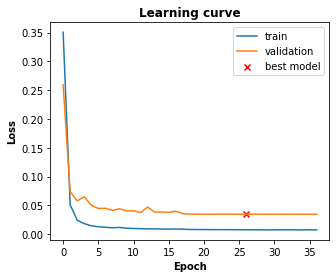

In [30]:
#%matplotlib auto
%matplotlib inline

# plot learning curve
plt.figure(figsize=(5, 4))
plt.title("Learning curve",fontweight="heavy")
plt.plot(results.history["loss"], label="train")
plt.plot(results.history["val_loss"], label="validation")
# plot the location of the best model
plt.scatter(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epoch",fontweight="heavy")
plt.ylabel("Loss",fontweight="heavy")
plt.legend()

plt.savefig('learningcurve.jpg', dpi=600, format='jpg')

In [26]:
# load the best model
model.load_weights('model_unet_624_uw_60.h5')

In [27]:
file_path_train = "Bent_data_624"
ids_train = next(os.walk(os.path.join(file_path_train, "image_train_valid_XYZ")))[2] 
print("No. of images = ", len(ids_train))
file_path_test = "Bent_data_624"
ids_test = next(os.walk(os.path.join(file_path_test, "image_test")))[2] 

No. of images =  3744


In [61]:
# Allocate the space for predicting training, validation and test label
n_classes = 4

slice_num = 624
im_height = 624
im_width = 624

X_1 = np.zeros((slice_num, im_height, im_width, 1), dtype=np.float32)
y_1 = np.zeros((slice_num, im_height, im_width, n_classes), dtype=np.float32)

X_2 = np.zeros((slice_num, im_height, im_width, 1), dtype=np.float32)
y_2 = np.zeros((slice_num, im_height, im_width, n_classes), dtype=np.float32)

X_3 = np.zeros((slice_num, im_height, im_width, 1), dtype=np.float32)
y_3 = np.zeros((slice_num, im_height, im_width, n_classes), dtype=np.float32)


In [85]:
print('Loading sample 1 data (Z direction)')
index = 0
for n in tqdm(range(slice_num*2, slice_num*3)):
    # Load images
    # img_to_array: convert image to array
    X = img_to_array(load_img(os.path.join(file_path_train, "image_train_valid_XYZ", "")+ids_train[n], color_mode = "grayscale"))
    X = resize(X, (624, 624, 1), mode = 'constant', preserve_range = True)
    mask = img_to_array(load_img(os.path.join(file_path_train, "mask_train_valid_XYZ", "")+ids_train[n], color_mode = "grayscale"))
    mask = resize(mask, (624, 624, 1), mode = 'constant', preserve_range = True)
    X_1[index] = X/255.0

    for c in range(n_classes):
          y_1[index, :, :, c] = (mask[:,:,0] == c).astype(int)
    
    index+=1
            
print('Loading sample 2 data (Z direction)')  
index = 0
for n in tqdm(range(slice_num*5, slice_num*6)):
    # Load images
    # img_to_array: convert image to array

    X = img_to_array(load_img(os.path.join(file_path_train, "image_train_valid_XYZ", "")+ids_train[n], color_mode = "grayscale"))
    X = resize(X, (624, 624, 1), mode = 'constant', preserve_range = True)
    mask = img_to_array(load_img(os.path.join(file_path_train, "mask_train_valid_XYZ", "")+ids_train[n], color_mode = "grayscale"))
    mask = resize(mask, (624, 624, 1), mode = 'constant', preserve_range = True)
    X_2[index] = X/255.0

    for c in range(n_classes):
          y_2[index, :, :, c] = (mask[:,:,0] == c).astype(int)
    
    index+=1

print('Loading sample 3 data (Z direction)') 
index = 0
for n in tqdm(range(slice_num*2, slice_num*3)):
    # Load images
    # img_to_array: convert image to array

    X = img_to_array(load_img(os.path.join(file_path_test, "image_test", "")+ids_test[n], color_mode = "grayscale"))
    X = resize(X, (624, 624, 1), mode = 'constant', preserve_range = True)
    mask = img_to_array(load_img(os.path.join(file_path_test, "mask_test", "")+ids_test[n], color_mode = "grayscale"))
    mask = resize(mask, (624, 624, 1), mode = 'constant', preserve_range = True)
    X_3[index] = X/255.0

    for c in range(n_classes):
          y_3[index, :, :, c] = (mask[:,:,0] == c).astype(int)
            
    index+=1   


Loading sample 1 data (Z direction)



Loading sample 2 data (Z direction)



Loading sample 3 data (Z direction)


In [86]:
preds_1 = model.predict(X_1, batch_size=5, verbose=1)
preds_2 = model.predict(X_2, batch_size=5, verbose=1)

import time
start = time.time()
print("hello")
preds_3 = model.predict(X_3, batch_size=5, verbose=1)
end = time.time()
print(end - start)


125/125 [==============================] - ETA:  - ETA: 1: - ETA: 1: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 57 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 51 - ETA: 50 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 40 - ETA: 39 

In [87]:
preds_1_t = preds_1
preds_2_t = preds_2
preds_3_t = preds_3

for c in range(n_classes):
      preds_1_t[preds_1[:,:,:,c] < 0.5, c] = 0
      preds_1_t[preds_1[:,:,:,c] >= 0.5, c] = 1
      
      preds_2_t[preds_2[:,:,:,c] < 0.5, c] = 0
      preds_2_t[preds_2[:,:,:,c] >= 0.5, c] = 1

      preds_3_t[preds_3[:,:,:,c] < 0.5, c] = 0
      preds_3_t[preds_3[:,:,:,c] >= 0.5, c] = 1

In [88]:
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap(['black', 'dodgerblue', 'darkgray', 'lime'])
boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

def plot_sample(X, y, preds, channel, ix=None, save = False):
    """Function to plot the results"""
    # ix is None, then random select image to plot
    if ix is None:
        ix = random.randint(0, len(X)-1)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5.25))
    # plot input seismic image
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    # If there is salt in the image, plot the boundary of salt as black line
    ax[0].set_title('Micro-CT',fontweight="heavy")
    # plot labels segmented with Otsu method
    ax[1].imshow(y[ix, ..., channel], cmap = cmap, norm=norm)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Segmented label (Image processing)',fontweight="heavy")
    # Plot predicted Labels
    ax[2].imshow(preds[ix, ..., channel], cmap = cmap, norm=norm)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title('Segmented label (U-net)',fontweight="heavy")
    fig.tight_layout()
    
    if save == True:
        plt.savefig('savedfig.jpg', dpi=600, format='jpg')
        

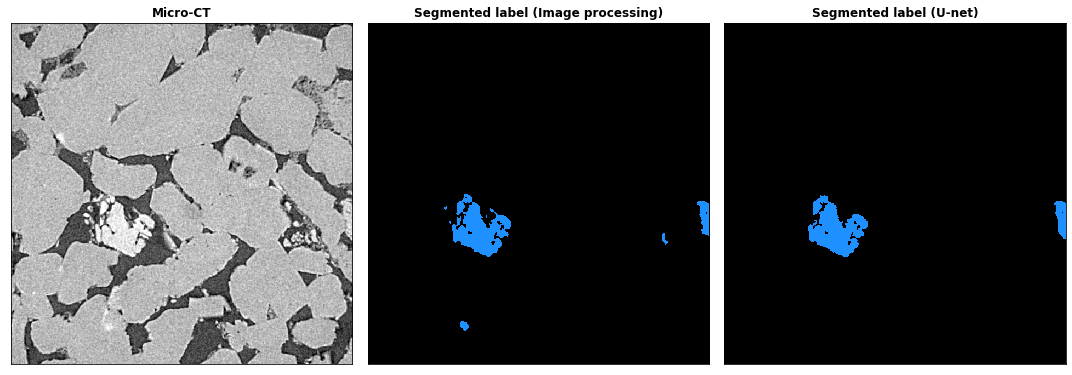

In [89]:
# Check if training data looks all right
plot_sample(X_1[:,:,:,:], y_1[:,:,:,:], preds_1_t, 3, ix=9)

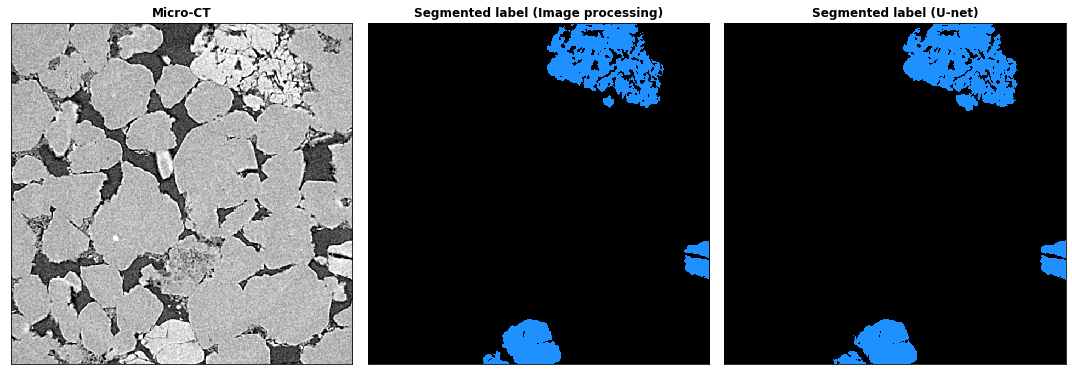

In [90]:
# Check if training data looks all right
plot_sample(X_1[:,:,:,:], y_1[:,:,:,:], preds_1_t, 3)

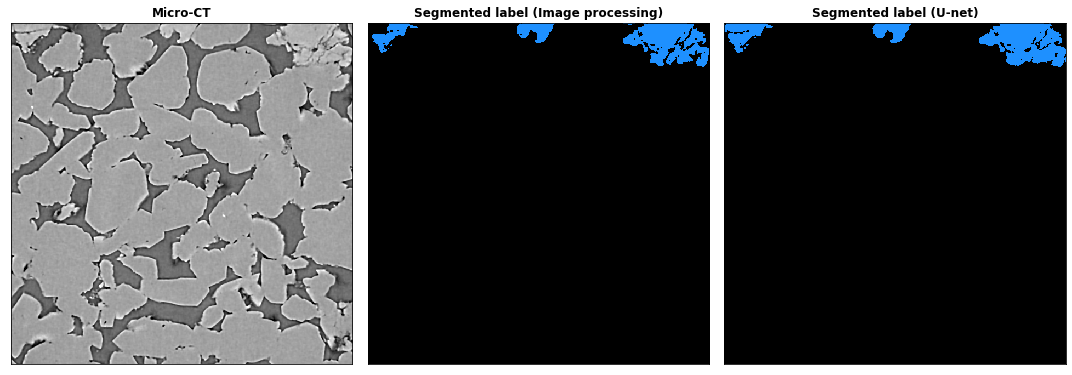

In [91]:
plot_sample(X_2[:,:,:,:], y_2[:,:,:,:], preds_2_t, 3)

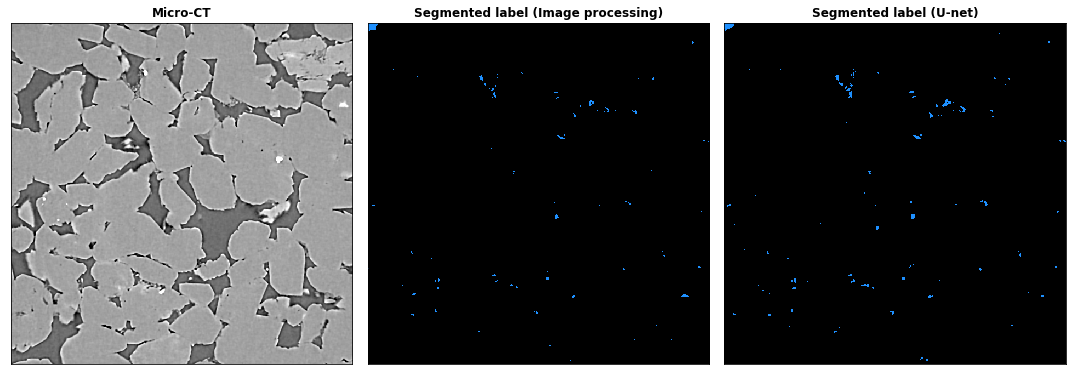

In [92]:
plot_sample(X_2[:,:,:,:], y_2[:,:,:,:], preds_2_t, 2)

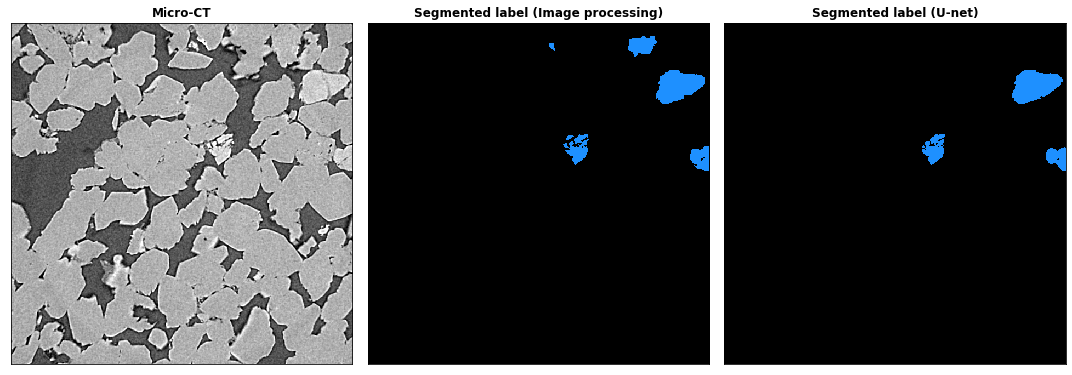

In [93]:
plot_sample(X_3, y_3, preds_3_t, 3)

In [94]:
y_1_com = np.zeros((slice_num, im_height, im_width, 1), dtype=np.float32)
preds_1_t_com = np.zeros((slice_num, im_height, im_width, 1), dtype=np.float32)

y_2_com = np.zeros((slice_num, im_height, im_width, 1), dtype=np.float32)
preds_2_t_com = np.zeros((slice_num, im_height, im_width, 1), dtype=np.float32)

y_3_com = np.zeros((slice_num, im_height, im_width, 1), dtype=np.float32)
preds_3_t_com = np.zeros((slice_num, im_height, im_width, 1), dtype=np.float32)

for i in range(slice_num):
    y_1_com[i,:,:,0]= y_1[i,:,:,0]*0 + y_1[i,:,:,1]*1 + y_1[i,:,:,2]*2 + y_1[i,:,:,3]*3
    preds_1_t_com[i,:,:,0]= preds_1_t[i,:,:,0]*0 + preds_1_t[i,:,:,1]*1 + preds_1_t[i,:,:,2]*2 + preds_1_t[i,:,:,3]*3    
    
for i in range(slice_num):   
    y_2_com[i,:,:,0]= y_2[i,:,:,0]*0 + y_2[i,:,:,1]*1 + y_2[i,:,:,2]*2 + y_2[i,:,:,3]*3
    preds_2_t_com[i,:,:,0]= preds_2_t[i,:,:,0]*0 + preds_2_t[i,:,:,1]*1 + preds_2_t[i,:,:,2]*2 + preds_2_t[i,:,:,3]*3
         
    
for i in range(slice_num): 
    y_3_com[i,:,:,0]= y_3[i,:,:,0]*0 + y_3[i,:,:,1]*1 + y_3[i,:,:,2]*2 + y_3[i,:,:,3]*3
    preds_3_t_com[i,:,:,0]= preds_3_t[i,:,:,0]*0 + preds_3_t[i,:,:,1]*1 + preds_3_t[i,:,:,2]*2 + preds_3_t[i,:,:,3]*3

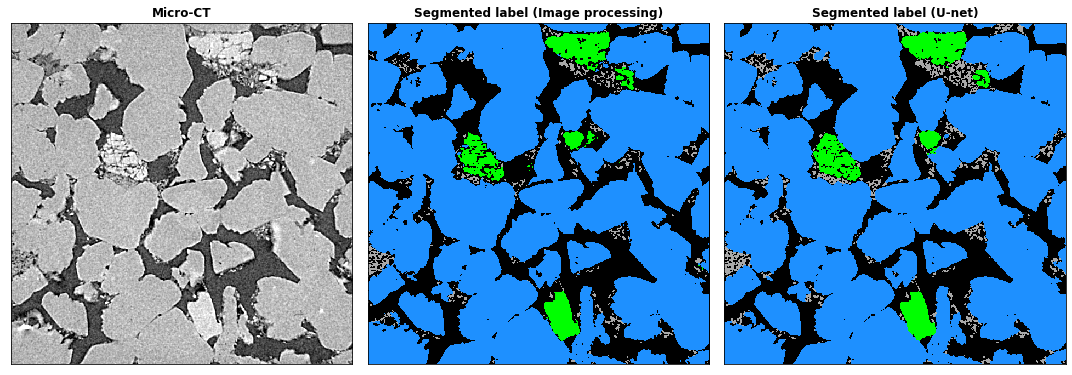

In [95]:
plot_sample(X_1[:,:,:,:], y_1_com[:,:,:,:], preds_1_t_com, 0, ix=559, save = True)

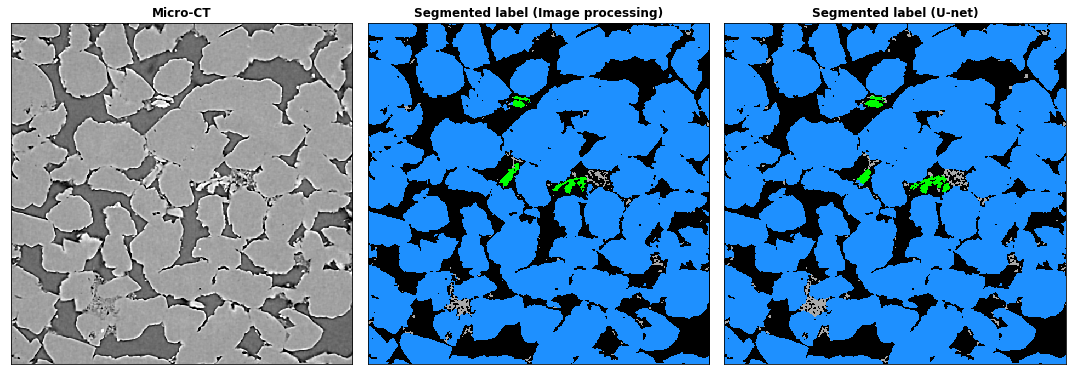

In [96]:
plot_sample(X_2[:,:,:,:], y_2_com[:,:,:,:], preds_2_t_com, 0)

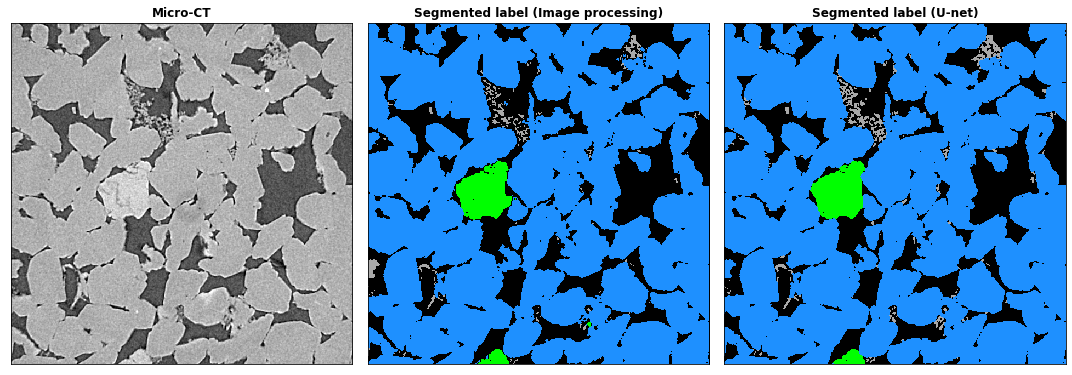

In [97]:
plot_sample(X_3[:,:,:,:], y_3_com[:,:,:,:], preds_3_t_com, 0)

In [134]:
# plot train, validation and test together

def plot_3sample(X1, y1, pred1, X2, y2, pred2, X3, y3, pred3, channel, ix1, ix2, ix3, save = False, file_name = "plot"):
    """Function to plot the results"""

    fig, ax = plt.subplots(3, 3, figsize=(15, 15.75))
    # plot input seismic image
    ax[0,0].imshow(X1[ix1, ..., 0], cmap='gray')
    ax[0,0].set_xticks([])
    ax[0,0].set_yticks([])
    # If there is salt in the image, plot the boundary of salt as black line
    ax[0,0].set_title('Micro-CT of Sample A',fontweight="heavy")
    # plot labels segmented with Otsu method
    ax[0,1].imshow(y1[ix1, ..., channel], cmap = cmap, norm=norm)
    ax[0,1].set_xticks([])
    ax[0,1].set_yticks([])
    ax[0,1].set_title('Segmented label (workflow)',fontweight="heavy")
    # Plot predicted Labels
    ax[0,2].imshow(pred1[ix1, ..., channel], cmap = cmap, norm=norm)
    ax[0,2].set_xticks([])
    ax[0,2].set_yticks([])
    ax[0,2].set_title('Segmented label (CNN)',fontweight="heavy")
    
    # plot input seismic image
    ax[1,0].imshow(X2[ix2, ..., 0], cmap='gray')
    ax[1,0].set_xticks([])
    ax[1,0].set_yticks([])
    # If there is salt in the image, plot the boundary of salt as black line
    ax[1,0].set_title('Micro-CT of Sample B',fontweight="heavy")
    # plot labels segmented with Otsu method
    ax[1,1].imshow(y2[ix2, ..., channel], cmap = cmap, norm=norm)
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    ax[1,1].set_title('Segmented label (workflow)',fontweight="heavy")
    # Plot predicted Labels
    ax[1,2].imshow(pred2[ix2, ..., channel], cmap = cmap, norm=norm)
    ax[1,2].set_xticks([])
    ax[1,2].set_yticks([])
    ax[1,2].set_title('Segmented label (CNN)',fontweight="heavy")
    
    # plot input seismic image
    ax[2,0].imshow(X3[ix3, ..., 0], cmap='gray')
    ax[2,0].set_xticks([])
    ax[2,0].set_yticks([])
    # If there is salt in the image, plot the boundary of salt as black line
    ax[2,0].set_title('Micro-CT of Sample C',fontweight="heavy")
    # plot labels segmented with Otsu method
    ax[2,1].imshow(y3[ix3, ..., channel], cmap = cmap, norm=norm)
    ax[2,1].set_xticks([])
    ax[2,1].set_yticks([])
    ax[2,1].set_title('Segmented label (workflow)',fontweight="heavy")
    # Plot predicted Labels
    ax[2,2].imshow(pred3[ix3, ..., channel], cmap = cmap, norm=norm)
    ax[2,2].set_xticks([])
    ax[2,2].set_yticks([])
    ax[2,2].set_title('Segmented label (CNN)',fontweight="heavy")
    fig.tight_layout()
    
    if save == True:
        plt.savefig(file_name + '.jpg', dpi=400, format='jpg')

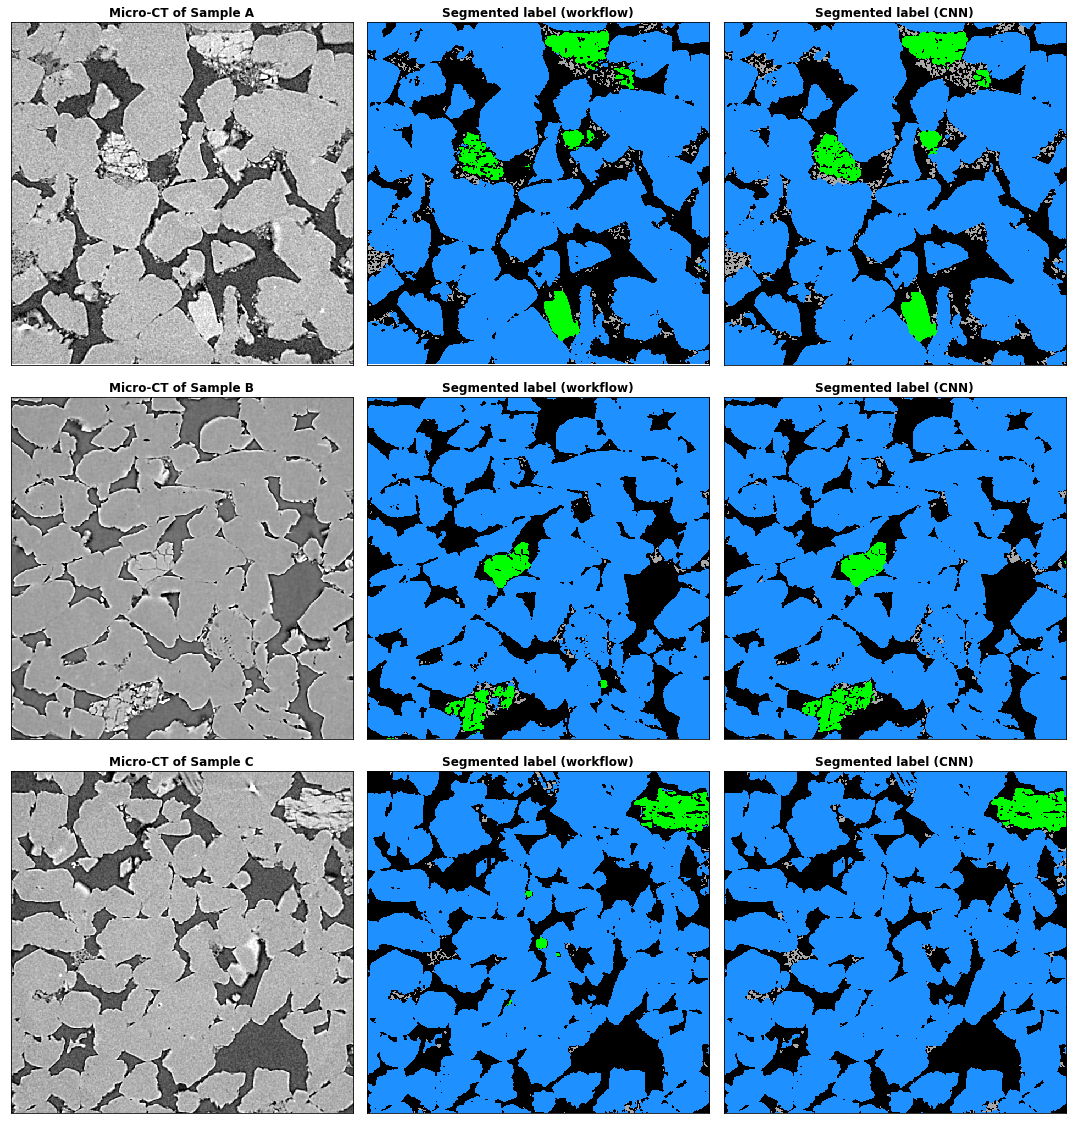

In [143]:
# good examples
plot_3sample(X_1[:,:,:,:], y_1_com[:,:,:,:], preds_1_t_com,\
             X_2[:,:,:,:], y_2_com[:,:,:,:], preds_2_t_com,\
             X_3[:,:,:,:], y_3_com[:,:,:,:], preds_3_t_com,\
             0, ix1=559, ix2=410, ix3=400, save = True)

In [138]:
# Give the total accuray
accu_t = accuracy_score(y_1_com[:,:,:,0].flatten(), preds_1_t_com[:,:,:,0].flatten())
print("The total accuracy of Sample A images is %f"  % accu_t)
# Give the accuracy of each phase
acc_0 = accuracy_score(y_1[:, :, :, 0].flatten(), preds_1_t[:, :, : , 0].flatten())
print("The accuracy of phase 1 is ", acc_0)
acc_1 = accuracy_score(y_1[:, :, :, 1].flatten(), preds_1_t[:, :, : , 1].flatten())
print("The accuracy of phase 2 is ", acc_1)
acc_2 = accuracy_score(y_1[:, :, :, 2].flatten(), preds_1_t[:, :, : , 2].flatten())
print("The accuracy of phase 3 is ", acc_2)
acc_3 = accuracy_score(y_1[:, :, :, 3].flatten(), preds_1_t[:, :, : , 3].flatten())
print("The accuracy of phase 4 is ", acc_3)

# Give the total accuray
accu_t = accuracy_score(y_2_com[:,:,:,0].flatten(), preds_2_t_com[:,:,:,0].flatten())
print("The total accuracy of Sample B images is %f"  % accu_t)
# Give the accuracy of each phase
acc_0 = accuracy_score(y_2[:, :, :, 0].flatten(), preds_2_t[:, :, : , 0].flatten())
print("The accuracy of phase 1 is ", acc_0)
acc_1 = accuracy_score(y_2[:, :, :, 1].flatten(), preds_2_t[:, :, : , 1].flatten())
print("The accuracy of phase 2 is ", acc_1)
acc_2 = accuracy_score(y_2[:, :, :, 2].flatten(), preds_2_t[:, :, : , 2].flatten())
print("The accuracy of phase 3 is ", acc_2)
acc_3 = accuracy_score(y_2[:, :, :, 3].flatten(), preds_2_t[:, :, : , 3].flatten())
print("The accuracy of phase 4 is ", acc_3)

# Give the total accuray
accu_t = accuracy_score(y_3_com[:,:,:,0].flatten(), preds_3_t_com[:,:,:,0].flatten())
print("The total accuracy of Sample C images is %f"  % accu_t)
# Give the accuracy of each phase
acc_0 = accuracy_score(y_3[:, :, :, 0].flatten(), preds_3_t[:, :, : , 0].flatten())
print("The accuracy of phase 1 is ", acc_0)
acc_1 = accuracy_score(y_3[:, :, :, 1].flatten(), preds_3_t[:, :, : , 1].flatten())
print("The accuracy of phase 2 is ", acc_1)
acc_2 = accuracy_score(y_3[:, :, :, 2].flatten(), preds_3_t[:, :, : , 2].flatten())
print("The accuracy of phase 3 is ", acc_2)
acc_3 = accuracy_score(y_3[:, :, :, 3].flatten(), preds_3_t[:, :, : , 3].flatten())
print("The accuracy of phase 4 is ", acc_3)


The total accuracy of Sample A images is 0.965152
The accuracy of phase 1 is  0.9750089541688792
The accuracy of phase 2 is  0.9780623850231376
The accuracy of phase 3 is  0.9862027147775692
The accuracy of phase 4 is  0.9968598796535996
The total accuracy of Sample B images is 0.973563
The accuracy of phase 1 is  0.9786172010654259
The accuracy of phase 2 is  0.9786023227235898
The accuracy of phase 3 is  0.9956895735675437
The accuracy of phase 4 is  0.996599193818591
The total accuracy of Sample C images is 0.968750
The accuracy of phase 1 is  0.97688954365117
The accuracy of phase 2 is  0.9739932223246873
The accuracy of phase 3 is  0.9934648025598354
The accuracy of phase 4 is  0.9964692439527175


In [139]:
# Give the total f1_score
f1_score_t = f1_score(y_1_com[:,:,:,0].flatten(), preds_1_t_com[:,:,:,0].flatten(), average='macro')
print("The total f1_score of training images is %f"  % f1_score_t)
# Give the f1_score of each phase
f1_0 = f1_score(y_1[:, :, :, 0].flatten(), preds_1_t[:, :, : , 0].flatten())
print("The f1 score of phase 1 is ", f1_0)
f1_1 = f1_score(y_1[:, :, :, 1].flatten(), preds_1_t[:, :, : , 1].flatten())
print("The f1 score of phase 2 is ", f1_1)
f1_2 = f1_score(y_1[:, :, :, 2].flatten(), preds_1_t[:, :, : , 2].flatten())
print("The f1 score of phase 3 is ", f1_2)
f1_3 = f1_score(y_1[:, :, :, 3].flatten(), preds_1_t[:, :, : , 3].flatten())
print("The f1 score of phase 4 is ", f1_3)


# Give the total f1_score
f1_score_t = f1_score(y_2_com[:,:,:,0].flatten(), preds_2_t_com[:,:,:,0].flatten(), average='macro')
print("The total f1_score of validation images is %f"  % f1_score_t)
# Give the f1_score of each phase
f1_0 = f1_score(y_2[:, :, :, 0].flatten(), preds_2_t[:, :, : , 0].flatten())
print("The f1 score of phase 1 is ", f1_0)
f1_1 = f1_score(y_2[:, :, :, 1].flatten(), preds_2_t[:, :, : , 1].flatten())
print("The f1 score of phase 2 is ", f1_1)
f1_2 = f1_score(y_2[:, :, :, 2].flatten(), preds_2_t[:, :, : , 2].flatten())
print("The f1 score of phase 3 is ", f1_2)
f1_3 = f1_score(y_2[:, :, :, 3].flatten(), preds_2_t[:, :, : , 3].flatten())
print("The f1 score of phase 4 is ", f1_3)


# Give the total f1_score
f1_score_t = f1_score(y_3_com[:,:,:,0].flatten(), preds_3_t_com[:,:,:,0].flatten(), average='macro')
print("The total f1_score of test images is %f"  % f1_score_t)
# Give the f1_score of each phase
f1_0 = f1_score(y_3[:, :, :, 0].flatten(), preds_3_t[:, :, : , 0].flatten())
print("The f1 score of phase 1 is ", f1_0)
f1_1 = f1_score(y_3[:, :, :, 1].flatten(), preds_3_t[:, :, : , 1].flatten())
print("The f1 score of phase 2 is ", f1_1)
f1_2 = f1_score(y_3[:, :, :, 2].flatten(), preds_3_t[:, :, : , 2].flatten())
print("The f1 score of phase 3 is ", f1_2)
f1_3 = f1_score(y_3[:, :, :, 3].flatten(), preds_3_t[:, :, : , 3].flatten())
print("The f1 score of phase 4 is ", f1_3)


The total f1_score of training images is 0.881469
The f1 score of phase 1 is  0.9317858798594595
The f1 score of phase 2 is  0.9852857856093683
The f1 score of phase 3 is  0.6868268255344782
The f1 score of phase 4 is  0.926770527843405
The total f1_score of validation images is 0.876199
The f1 score of phase 1 is  0.9520371449500198
The f1 score of phase 2 is  0.9853348971161769
The f1 score of phase 3 is  0.658176122490477
The f1 score of phase 4 is  0.9097210264604002
The total f1_score of test images is 0.846302
The f1 score of phase 1 is  0.9521523012306721
The f1 score of phase 2 is  0.9817851453631263
The f1 score of phase 3 is  0.604012542030591
The f1 score of phase 4 is  0.8490557870892526


In [140]:
# Give the percentage of each phase

label1 = preds_1_t_com[:,:,:,0].flatten()
print("The percentage of phase 1 in Sample A is ", np.count_nonzero(label1 == 0) / (624*624*624))
print("The percentage of phase 2 in Sample A is ", np.count_nonzero(label1 == 1) / (624*624*624))
print("The percentage of phase 3 in Sample A is ", np.count_nonzero(label1 == 2) / (624*624*624))
print("The percentage of phase 4 in Sample A is ", np.count_nonzero(label1 == 3) / (624*624*624))

label2 = preds_2_t_com[:,:,:,0].flatten()
print("The percentage of phase 1 in Sample B is ", np.count_nonzero(label2 == 0) / (624*624*624))
print("The percentage of phase 2 in Sample B is ", np.count_nonzero(label2 == 1) / (624*624*624))
print("The percentage of phase 3 in Sample B is ", np.count_nonzero(label2 == 2) / (624*624*624))
print("The percentage of phase 4 in Sample B is ", np.count_nonzero(label2 == 3) / (624*624*624))

label3 = preds_3_t_com[:,:,:,0].flatten()
print("The percentage of phase 1 in Sample C is ", np.count_nonzero(label3 == 0) / (624*624*624))
print("The percentage of phase 2 in Sample C is ", np.count_nonzero(label3 == 1) / (624*624*624))
print("The percentage of phase 3 in Sample C is ", np.count_nonzero(label3 == 2) / (624*624*624))
print("The percentage of phase 4 in Sample C is ", np.count_nonzero(label3 == 3) / (624*624*624))

The percentage of phase 1 in Sample A is  0.19666158901579806
The percentage of phase 2 in Sample A is  0.7536689990967796
The percentage of phase 3 in Sample A is  0.027467719719071883
The percentage of phase 4 in Sample A is  0.02220169216835036
The percentage of phase 1 in Sample B is  0.2340848743920582
The percentage of phase 2 in Sample B is  0.7386642428016319
The percentage of phase 3 in Sample B is  0.00737284191195064
The percentage of phase 4 in Sample B is  0.019878040894359312
The percentage of phase 1 in Sample C is  0.25383767380866584
The percentage of phase 2 in Sample C is  0.7246492687115954
The percentage of phase 3 in Sample C is  0.010494223367512939
The percentage of phase 4 in Sample C is  0.011018834112225847
